# Calcul de features

Ce notebook calcul queqlues features sur les signaux. l'objectif est d'avoir une base a entrainer pour un modèle Machine learning
* 1 . on regarde le début du signal car c'est important, des signaux sont classés avec très peu de points
* 2 . calcul d'attributs sur les pics (les ondes)
* 3 . calcul avec catch22

## Initialisation

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy import signal
from scipy.ndimage import gaussian_filter

Matplotlib is building the font cache; this may take a moment.


In [3]:
df = pd.read_csv('../data/raw/mitbih_train.csv',header=None)
target = df.pop(187)
X = np.array(df)
y =  np.array(target)

In [4]:
dict_target = {0: 'Normal',
               1:'Supraventricular premature beat',
               2:'Premature ventricular contraction',
               3:'Fusion of ventricular and normal beat',
              4: 'Unclassifiable beat'}
target_str = target.replace(dict_target)
Fs = 125

### Fonction d'affichage

index_of_class est un dictionnaire dont les cles sont les classes et les valeurs sont les indices des signaux qui appartiennent a la classe

In [ ]:
index_of_class = {}
for k in range(5):
    index_of_class[k] =  [i for i, x in enumerate(target==k) if x]

In [53]:
# fonction pour afficher des signaux 
# affiche N signaux parmis les indices list_of_index   soit les uns au dessus des autres(overlay=False) soit supperposé (overlay=True)

def display_N_signals(X,N,list_of_index,ax=None,overlay=False,color='k',Fs=125):
    """
    X = matrice des signaux d'entrée
    N = nombre de signaux que l'on souhaite afficher
    list_of_index : list : on doit choisir N signaux parmi ces indices
    overlay : bool supperposition (False) ou les uns sur les autres (True)
    color : couleur des traces 
    Fs = sampling frequency
    """
    
    last_s = X.shape[1]
    t= np.arange(last_s)/Fs
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot()
    list_ii = np.random.choice(list_of_index,N)
    w = 0 if overlay else 1
    for kii,ii in enumerate(list_ii):
        ax.plot(t,X[ii,:]-np.mean(X[ii,:])+w*kii*0.75,color=color)
        if not overlay:
            ax.text(t[-1],kii*0.75,ii)
    return  ax

## signal synthetique normal

<img src="https://ecgwaves.com/wp-content/uploads/2018/01/ekg-ecg-interpretation-p-qrs-st-t-wave.jpg" width=800 />


## features debut du signal

post visualisation du signal, ces critères semblent important dans la calssification du signal car ceratin signaux sont classifiés ave très peu d'échantillons:
* pente du debut du signal
* range du début du signal
* hauteurs, positions et largeurs des pics

Pour ces calculs, on prend max 6 echantillons car le pic QRS devrait durer moins de 0.12s, donc on cherche la pente d'une moitié de cette durée, soit 0.06s max, plutot 0.05 pour est vraiment sur la descente.

In [6]:
nech = 6

#### Pente du debut du signal

Text(0, 0.5, '')

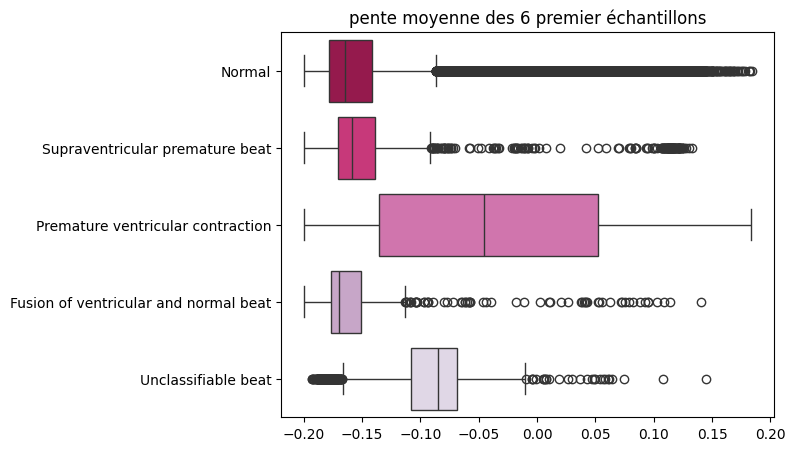

In [7]:
pente_start = np.mean(np.diff(X[:,0:nech],axis=1),axis=1)
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(121)
sns.boxplot(y=target_str,x=pente_start,ax=ax,hue =target_str, palette='PuRd_r')
#ax.tick_params(axis='x', labelrotation=45)
ax.set_title('pente moyenne des %d premier échantillons' %nech)
ax.set_ylabel('')


La classe Premature ventricular contraction est plus homogène  avec une pente plutot faible, les pentes positives nétant pas outliers
Les pentes positives sur la classe "normal" sont très nombreuses mais reste outliers.
ci dessous comparaison de la pente sur 10 signaux au hasard de la classe 2 avec une pente de distribution plus plate que la classe 1

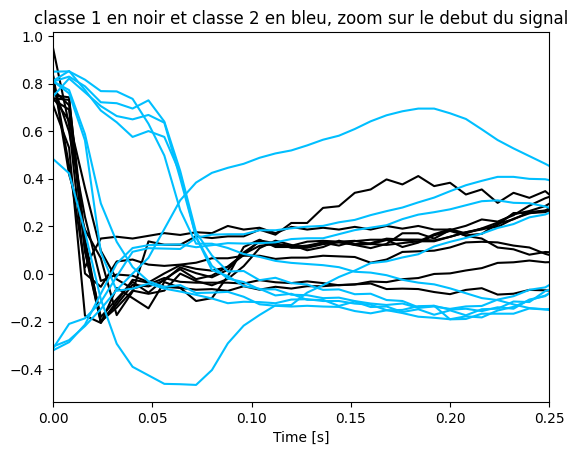

In [8]:
ax = display_N_signals(X,10,index_of_class[1],ax=None,overlay=True,color='k')
ax = display_N_signals(X,10,index_of_class[2],ax=ax,overlay=True,color='deepskyblue')
ax.set_xlim([0,0.25])
ax.set_title('classe 1 en noir et classe 2 en bleu, zoom sur le debut du signal'            )
ax.set_xlabel('Time [s]');

#### Range

le range nous renseigne sur l'amplitude de la première descente (ou montée)

In [9]:
range_start = np.max(X[:,0:nech],axis=1)-np.min(X[:,0:nech],axis=1)


C:\Users\carol\AppData\Local\Temp\ipykernel_16268\3080070572.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(y=target_str,x=range_start,ax=ax,palette='PuRd_r')


Text(0.5, 1.0, 'range des 6 premiers échantillons')

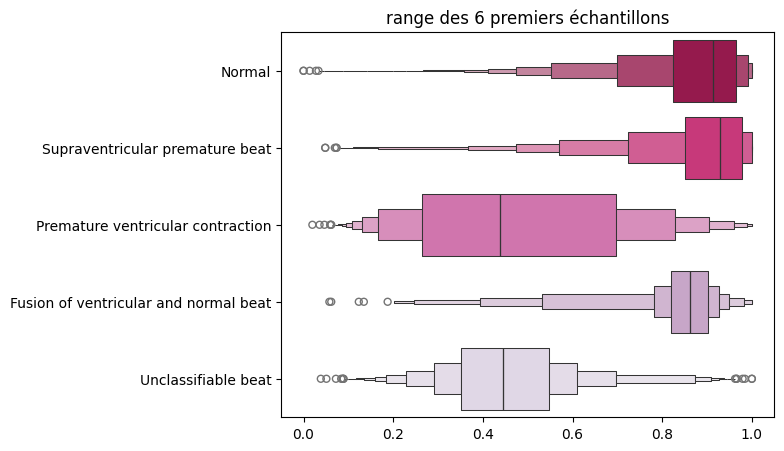

In [10]:
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(121)
sns.boxenplot(y=target_str,x=range_start,ax=ax,palette='PuRd_r')
ax.set_ylabel('')
ax.set_title('range des %d premiers échantillons' %nech)

Sur le range, les classes 2 et 4 se distinguent avec des ranges plus faibles, la distributions sur les autres classes est plutot similaire, surtout pour 0 et 1

### Mediane

C:\Users\carol\AppData\Local\Temp\ipykernel_16268\417249529.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(y=target_str,x=median_start,ax=ax,palette='PuRd_r')


Text(0, 0.5, '')

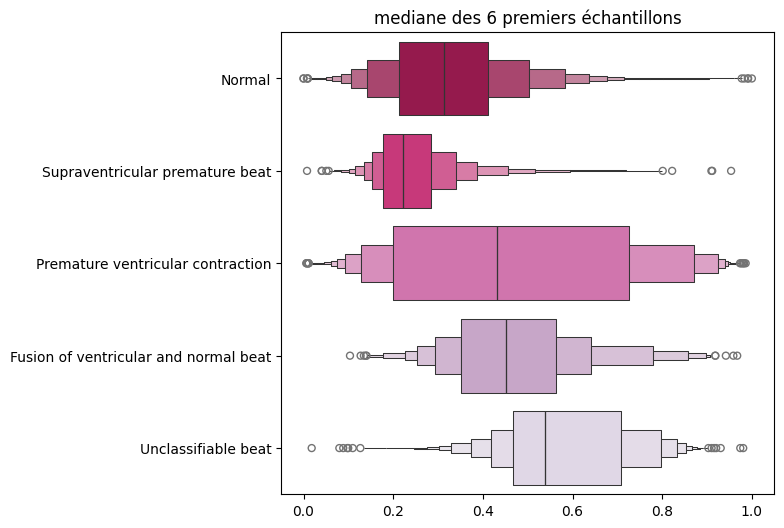

In [11]:
median_start = np.median(X[:,0:nech],axis=1)
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
sns.boxenplot(y=target_str,x=median_start,ax=ax,palette='PuRd_r')
ax.set_title('mediane des %d premiers échantillons' %nech)
ax.set_ylabel('')


la distribution de la médiane est spécifique à chaque classe, cela doit être un bon attribut. la classe 2 couvre l'ensemble 0 1, cela sera peut etre moins facile pour cette classe

### std

C:\Users\carol\AppData\Local\Temp\ipykernel_16268\4255384641.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(y=target_str,x=std_start,ax=ax,palette='PuRd_r')


Text(0, 0.5, '')

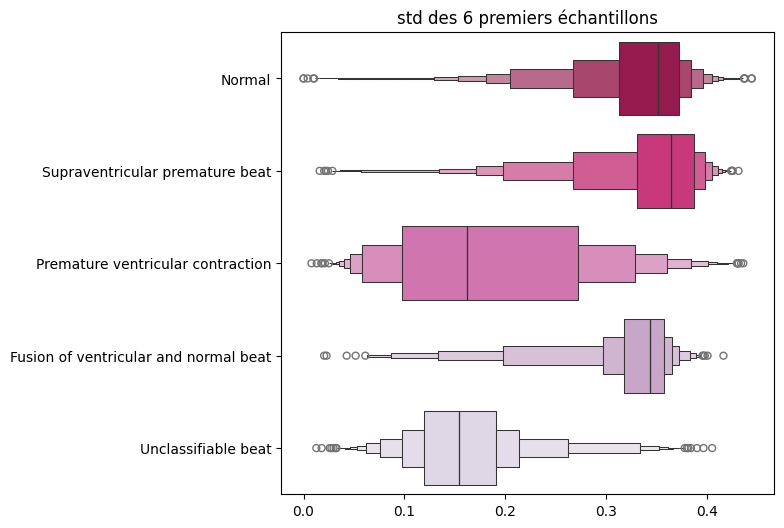

In [12]:
std_start = np.std(X[:,0:nech],axis=1)
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
sns.boxenplot(y=target_str,x=std_start,ax=ax,palette='PuRd_r')
ax.set_title('std des %d premiers échantillons' %nech)
ax.set_ylabel('')


les classes 2 et 4 se distinguent dans leur distribution

## features de pics

les pics sont probablement la clé de la classification. pour mieux les caractériser, il est préférable de lisser le signal légèrement pour gommer les sous pics

#### lissage

on regarde ici plusieurs facon de faire du smoothing. on affiche un example de la classe "normal"

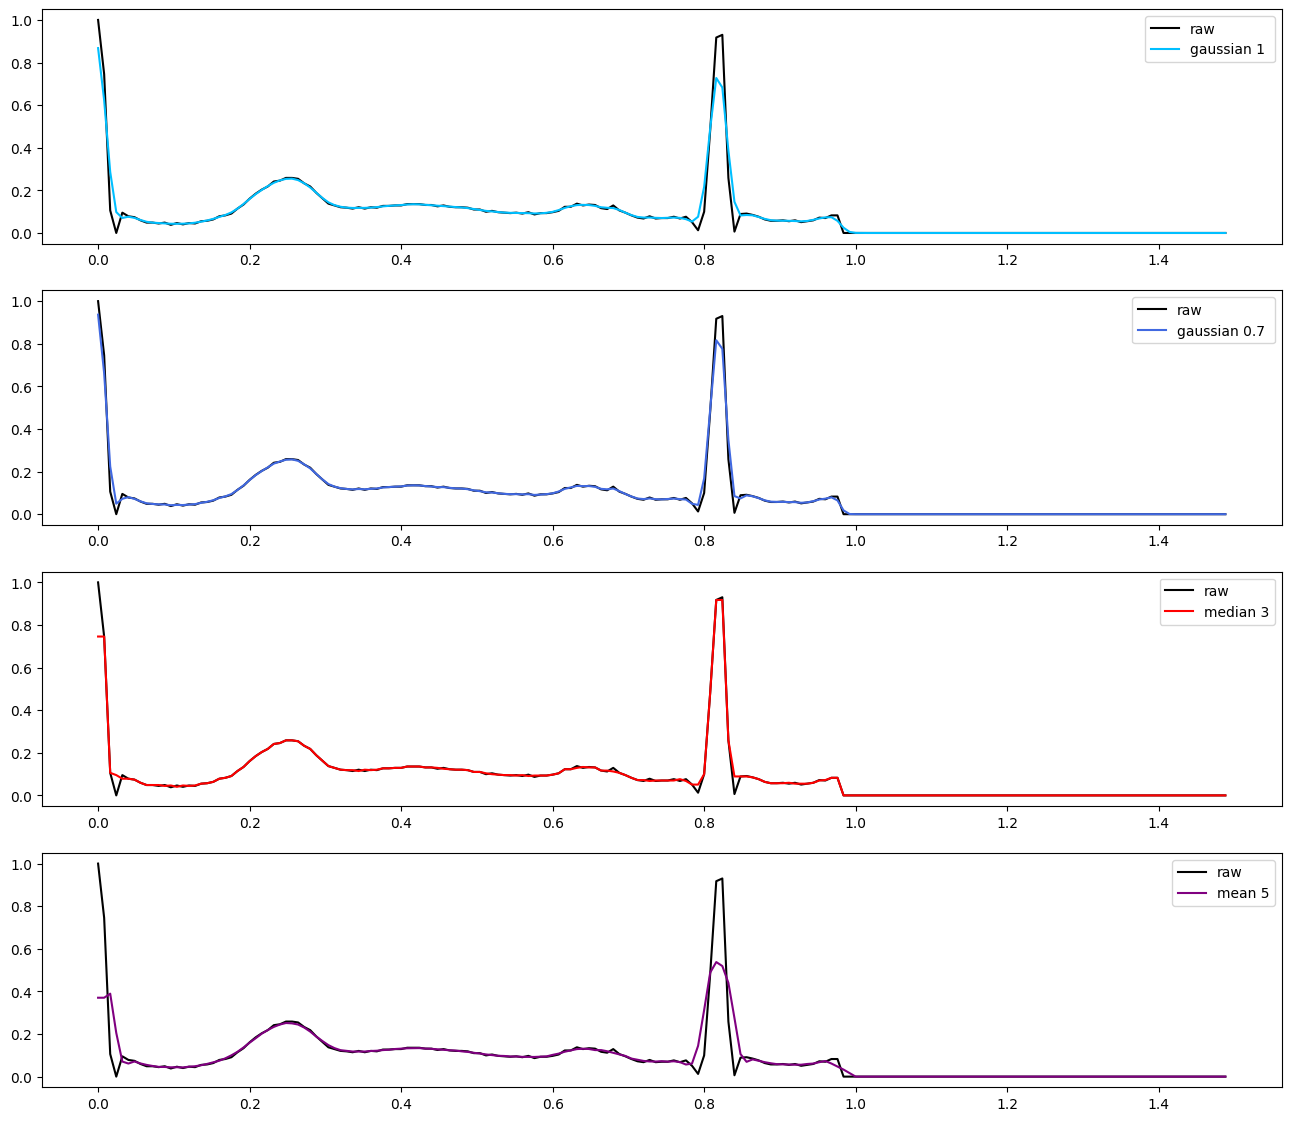

In [13]:
fig,axs = plt.subplots(nrows=4, ncols=1,figsize=(16,14))
list_ii = np.random.choice(index_of_class[0],1)
ii = list_ii[0]
t = np.arange(X.shape[1])/Fs
axs[0].plot(t,X[ii,:],color='k',label='raw')
axs[0].plot(t,gaussian_filter(X[ii,:],1,order=0),color='deepskyblue',label='gaussian 1 ')
axs[1].plot(t,X[ii,:],color='k',label='raw')
axs[1].plot(t,gaussian_filter(X[ii,:],0.7),color='royalblue',label='gaussian 0.7 ')
axs[2].plot(t,X[ii,:],color='k',label='raw')
axs[2].plot(t,signal.medfilt(X[ii,:],3),color='red',label='median 3')
axs[3].plot(t,X[ii,:],color='k',label='raw')
axs[3].plot(t,signal.convolve(X[ii,:],np.ones(5)/5,mode='same'),color='purple',label='mean 5')

for k in range(4):
    axs[k].legend()

le smoothing moyen gomme les pentes raides et diminue la hauteur des pics. les autres sont assez equivalents. le gaussian filter de noyau 1 aura plus d'impact sur le gommage des petits pics, mais réduira un peut plus la hauteur.
cela n'a pas l'air d'être trop fort

#### hauteur, position largeur des 3 pics principaux

In [14]:
def get_waves(x,delay=10,applyfilter='gaussian',paramfilter=1):
    """
    x : 1d array : signal
    delay : number of sample to skip at the beggining of the signal
    applyfilter: smoothing method
        - gaussian filter of kernel paramfilter
        - median : apply median filter : paramfilter = window size in samples
        - mean : appply mean filter: paramfilter = window size in samples
    outputs
    #############
        R,R_prominence : position et prominence du pic principal qui devrait etre l'onde R
        P1,P1_width,P1_height,P1_prominence, position, largeur, hauteur et prominence du 1er pic secondaire
        P2,P2_width,P2_height,P2_prominence, position, largeur, hauteur et prominence du 2e pic secondaire

    """
    n_zeros_pad = np.argmax( np.flip(x)!=0)
    signal_dur_sample = -n_zeros_pad + x.shape[0]

    if applyfilter=='gaussian':
        x1 = gaussian_filter(x,paramfilter)
    elif applyfilter=='median':
        x1 = signal.medfilt(x,paramfilter)
    elif applyfilter=='mean':
        x1 = signal.convolve(X[ii,:],np.ones(paramfilter)/paramfilter,mode='same')
    # trouve le pic principal et verifie qu'il est assez à la fin 
    # on  fait ca sur le signal non filtré pour le pic principal
    peaks, properties = signal.find_peaks(x[delay:signal_dur_sample+1],height=(None,None),plateau_size=(None,None),
                                          prominence=(0.2,None),width=(None,None),distance=10)
    
    if len(peaks):
        imax_pro = np.argmax(properties['prominences'])
        R = peaks[imax_pro]+delay
        R_prominence = properties['prominences'][imax_pro]
        R_height = properties['peak_heights'][imax_pro]
        R_width = properties['widths'][imax_pro]
        istop = R-5
        if R<signal_dur_sample/2:
            R = 0
            R_prominence = 0
            istop = signal_dur_sample
            R_height = 0 
            R_width = 0
    else:
        R = 0
        R_prominence = 0
        istop = signal_dur_sample
        R_height = 0
        R_width = 0 
    # on  fait ca sur le signal  filtré pour les pics secondaires
    peaks, properties = signal.find_peaks(x1[delay:istop],height=(None,None),plateau_size=(None,None),
                                          prominence=(None,None),width=(None,None),distance=10)
    if len(peaks)>0:
        imax_width = np.argmax(properties['widths']*properties['prominences'])
        P1 = peaks[imax_width]+delay
        P1_width = properties['widths'][imax_width]
        P1_height = properties['peak_heights'][imax_width]
        P1_prominence = properties['prominences'][imax_width]
        properties['widths'][imax_width] = 0

        imax_width = np.argmax(properties['widths']*properties['prominences'])
        P2 = peaks[imax_width]+delay
        P2_width = properties['widths'][imax_width]
        P2_height = properties['peak_heights'][imax_width]
        P2_prominence = properties['prominences'][imax_width]
    else:
        P1=0
        P1_width=0
        P1_height=0
        P1_prominence =0
        P2=0
        P2_width=0
        P2_height=0
        P2_prominence =0
        
    if P2<P1:
        P2,P1 = P1,P2
        P2_prominence,P1_prominence = P1_prominence,P2_prominence
        P2_width,P1_width = P1_width,P2_width
        P2_height,P1_height = P1_height,P2_height

    return R,R_width,R_height,R_prominence,P1,P1_width,P1_height,P1_prominence,P2,P2_width,P2_height,P2_prominence,signal_dur_sample

Calcul des attributs

In [15]:
Points = np.zeros((X.shape[0],13))
check=[]
for k in range(X.shape[0]):
    try:
        Points[k,:] = get_waves(X[k,:])
    except:
        check.append(k)

vérification q'uil n'y a pas eu d'erreurs

In [16]:
print(len(check))

0


Conversion en dataframe

In [17]:
Waves = pd.DataFrame(data=Points
                     ,columns=['R','R_width','R_height','R_prominence','P1','P1_width','P1_height','P1_prominence','P2','P2_width','P2_height','P2_prominence','dur'])
Waves.head()

,R,R_width,R_height,R_prominence,P1,P1_width,P1_height,P1_prominence,P2,P2_width,P2_height,P2_prominence,dur
0,83.0,4.923556,1.000000,1.000000,34.0,17.300977,0.153833,0.055834,65.0,8.667336,0.238342,0.164680,100.0
1,115.0,4.085560,1.000000,0.997151,34.0,12.380530,0.285026,0.219753,74.0,15.999550,0.110426,0.079874,137.0
2,82.0,2.511900,0.964865,0.959459,29.0,11.118379,0.318149,0.266873,62.0,7.181010,0.103459,0.068811,95.0
3,80.0,4.508514,1.000000,1.000000,28.0,6.257846,0.139043,0.070692,54.0,16.078042,0.247398,0.237087,96.0
4,117.0,5.901112,0.953052,0.953052,33.0,14.258902,0.252878,0.120345,98.0,9.333426,0.110282,0.056769,140.0


#### verification des pics

affiche les signaux et les attributs calculés sur les pics

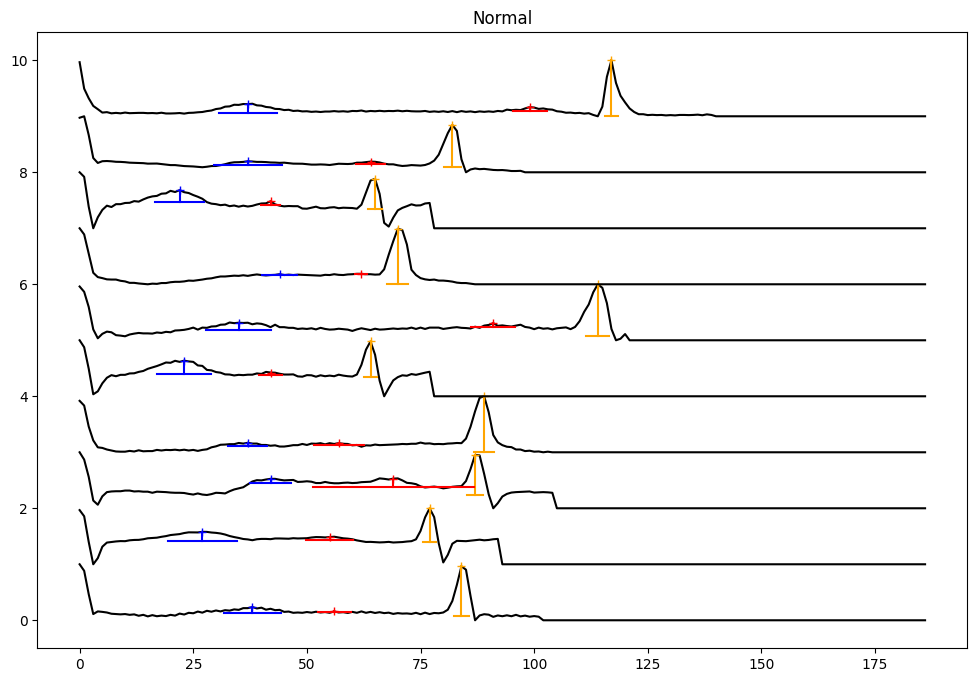

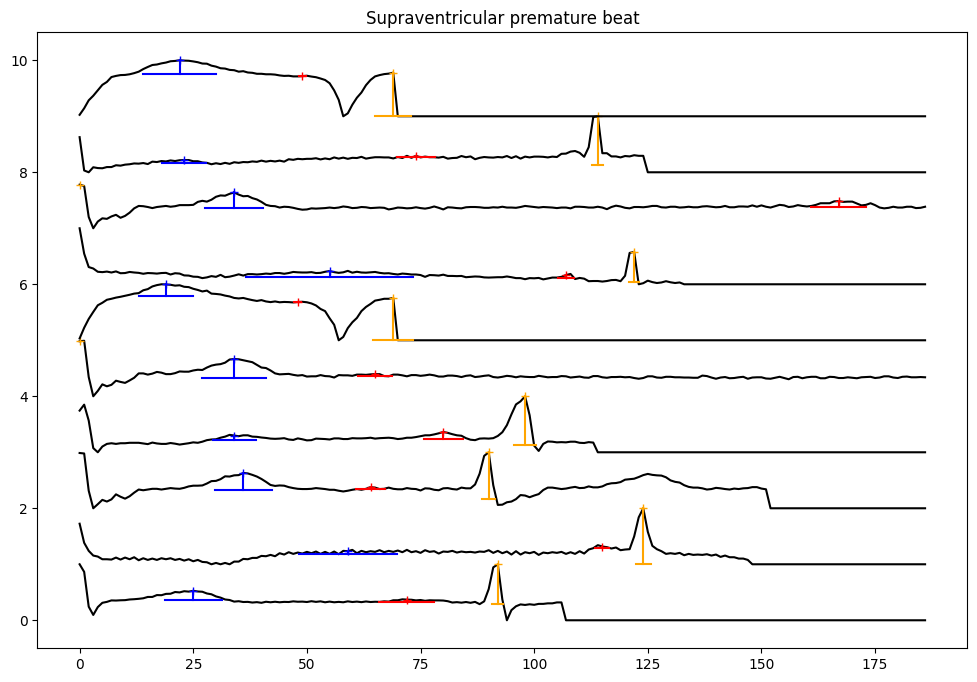

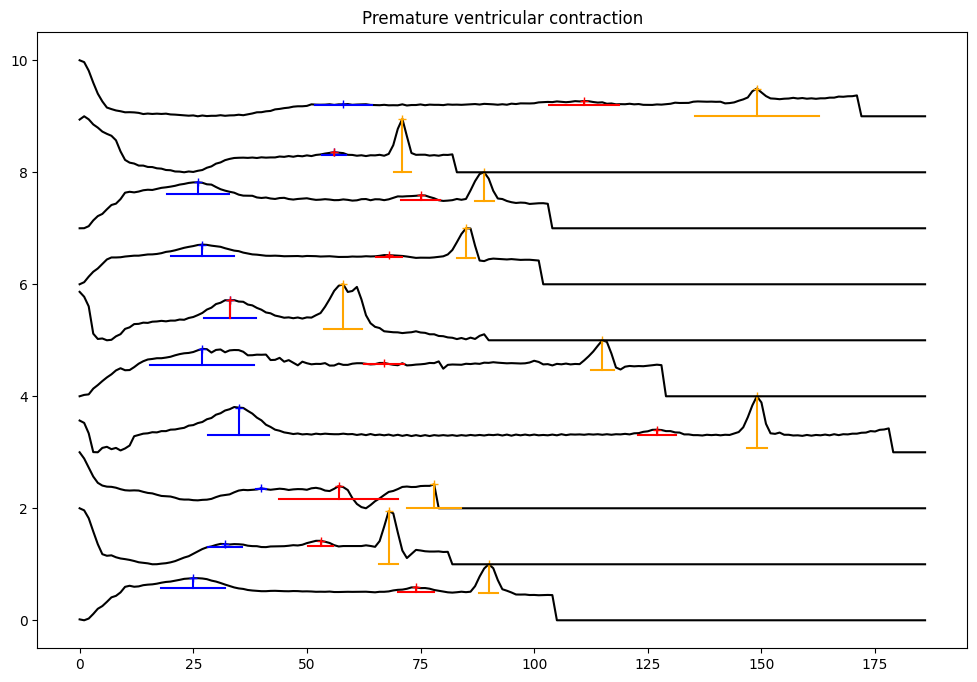

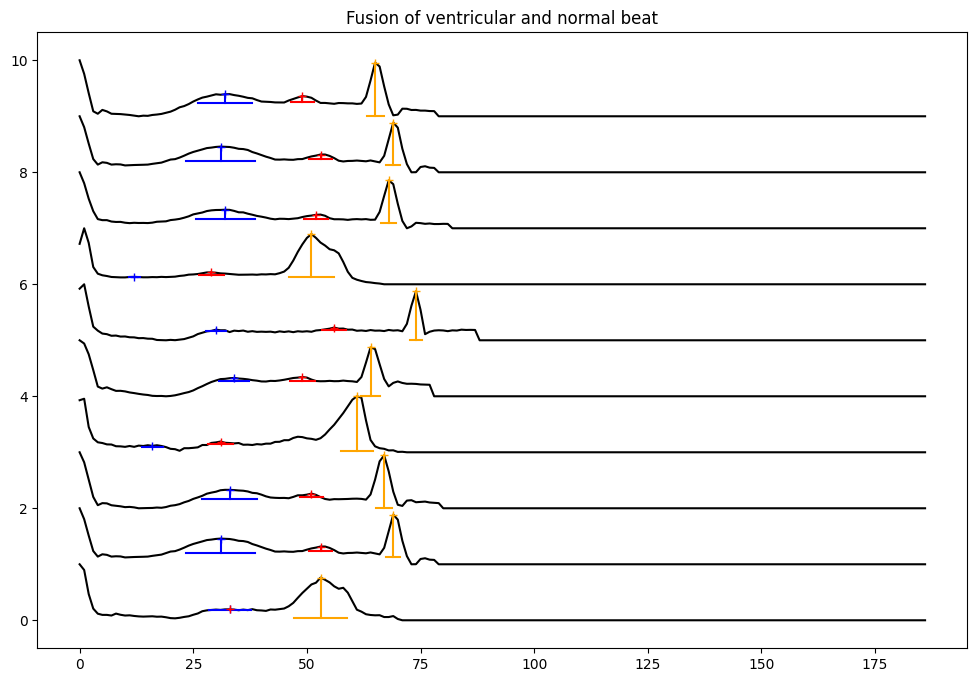

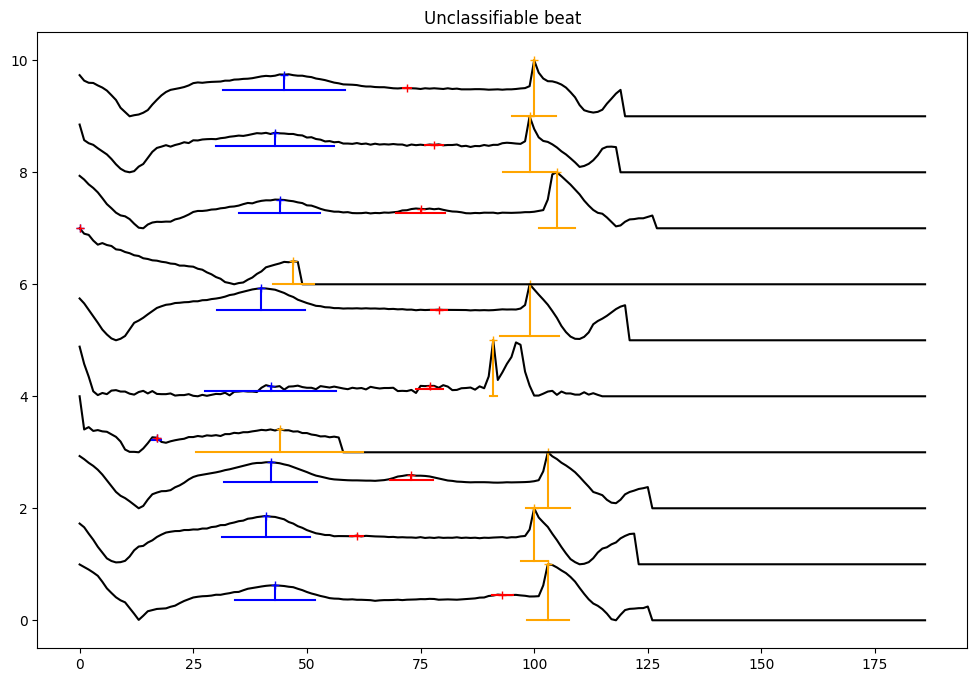

In [18]:
N = 10 # affiche 10 signaux au hasard
for classe in range(5):
    fig,axs = plt.subplots(nrows=1, ncols=1,figsize=(12,8))

    list_ii = np.random.choice(index_of_class[classe],N)
    for kii,ii in enumerate(list_ii):
        axs.plot(X[ii,:]+kii,color='k')
        
        pos_R = int(Waves.loc[ii, 'R'])
        y_R = X[ii, pos_R]
        prom_R =Waves.loc[ii, 'R_prominence']
        width_R = Waves.loc[ii, 'R_width']

        axs.plot(pos_R,y_R + kii, color='orange', marker='+')
        axs.plot([pos_R,pos_R],[y_R + kii, y_R - prom_R + kii],color='orange')
        axs.plot([pos_R - width_R/2,pos_R + width_R/2],[y_R - prom_R + kii, y_R - prom_R + kii], color='orange')

        pos_P1 = int(Waves.loc[ii,'P1'])
        y_P1 = X[ii,pos_P1]
        prom_P1 = Waves.loc[ii,'P1_prominence']
        width_P1 = Waves.loc[ii,'P1_width']
        
        axs.plot(pos_P1, y_P1 + kii, color='blue', marker='+')
        axs.plot([pos_P1, pos_P1], [y_P1 + kii, y_P1 - prom_P1 + kii],color='blue')
        axs.plot([pos_P1 - width_P1/2, pos_P1 + width_P1/2], [y_P1 - prom_P1 + kii, y_P1 - prom_P1 + kii], color='blue')

        pos_P2 = int(Waves.loc[ii, 'P2'])
        y_P2 = X[ii,pos_P2]
        prom_P2 = Waves.loc[ii, 'P2_prominence']
        width_P2 = Waves.loc[ii, 'P2_width']

        axs.plot(pos_P2, y_P2 + kii, color='red', marker='+')
        axs.plot([pos_P2, pos_P2], [y_P2 + kii, y_P2 - prom_P2 + kii],color='red')
        axs.plot([pos_P2 - width_P2/2, pos_P2 + width_P2/2], [y_P2 - prom_P2 + kii, y_P2 - prom_P2 + kii], color='red')

    
    axs.set_title(dict_target[classe]) 

le calcul des pics n'est pas fiable à 100%

Transfomes les indice en temps, ca les normalise d'une certaine façon, ils seront entre 0 et 1.5 

In [21]:
for col in ['R','P1','P2','R_width','P1_width','P2_width','dur']:
    Waves.loc[:,col] /= Fs

#### distribution des 3 pics trouvés

C:\Users\carol\AppData\Local\Temp\ipykernel_16268\2201706443.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=Waves,x=target_str,y='R',ax=ax,palette='PuRd_r')
C:\Users\carol\AppData\Local\Temp\ipykernel_16268\2201706443.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=Waves,x=target_str,y='P1',ax=ax,palette='PuRd_r')
C:\Users\carol\AppData\Local\Temp\ipykernel_16268\2201706443.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=Waves,x=target_str,y='P2',ax=ax,palette='PuRd_r')


Text(0.5, 1.0, 'deuxième pic secondaire')

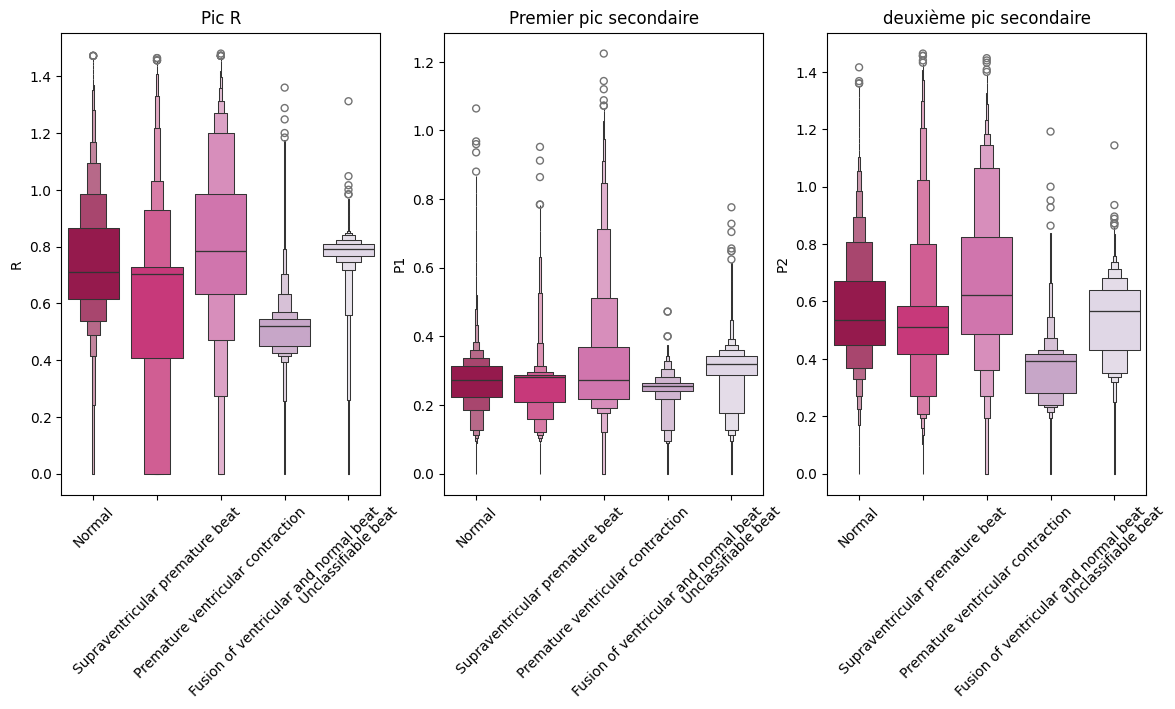

In [56]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(131)
sns.boxenplot(data=Waves,x=target_str,y='R',ax=ax,palette='PuRd_r')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('')
ax.set_title('Pic R')
ax = fig.add_subplot(132)
sns.boxenplot(data=Waves,x=target_str,y='P1',ax=ax,palette='PuRd_r')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('')
ax.set_title('Premier pic secondaire')

ax = fig.add_subplot(133)
sns.boxenplot(data=Waves,x=target_str,y='P2',ax=ax,palette='PuRd_r')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('')
ax.set_title('deuxième pic secondaire')


#### distribution des largeurs des 3 pics trouvés

C:\Users\carol\AppData\Local\Temp\ipykernel_16268\2792017491.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=Waves,x=target_str,y='R_width',ax=ax,palette='PuRd_r')
C:\Users\carol\AppData\Local\Temp\ipykernel_16268\2792017491.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=Waves,x=target_str,y='P1_width',ax=ax,palette='PuRd_r')
C:\Users\carol\AppData\Local\Temp\ipykernel_16268\2792017491.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=Waves,x=target_str,y='P2_width',ax=ax,palette='PuRd_r')


Text(0.5, 1.0, 'largeur second pic secondaire')

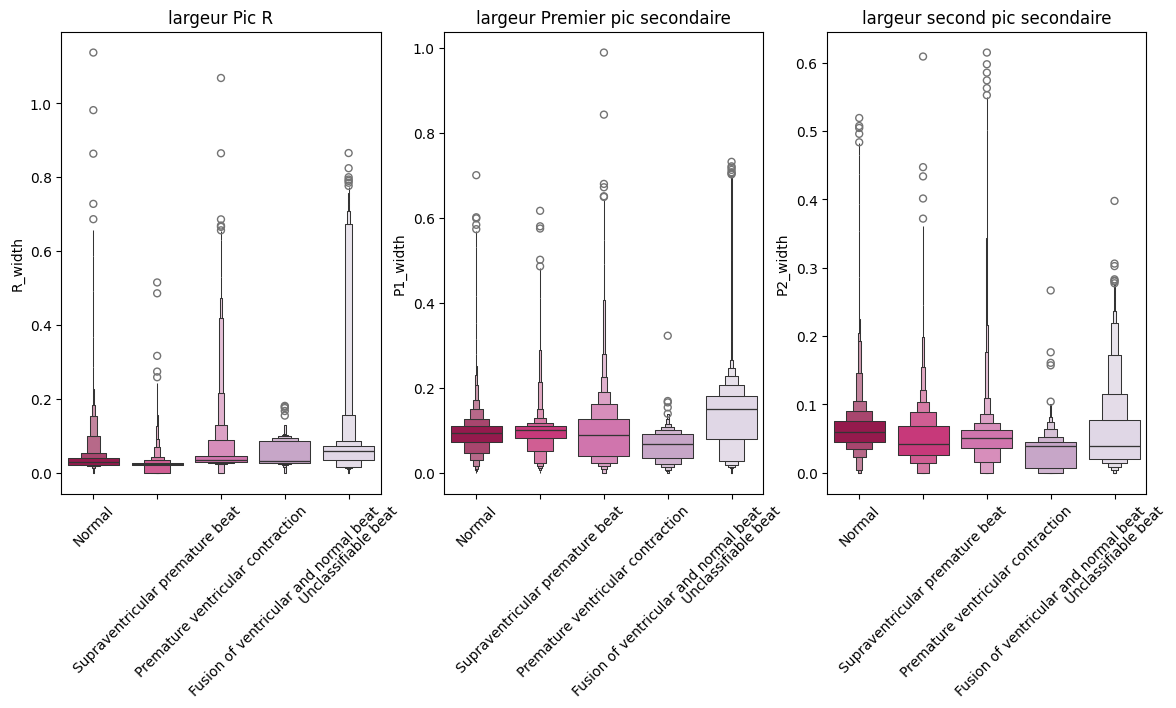

In [58]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(131)
sns.boxenplot(data=Waves,x=target_str,y='R_width',ax=ax,palette='PuRd_r')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('')
ax.set_title('largeur Pic R')
ax = fig.add_subplot(132)

sns.boxenplot(data=Waves,x=target_str,y='P1_width',ax=ax,palette='PuRd_r')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('')
ax.set_title('largeur Premier pic secondaire')

ax = fig.add_subplot(133)
sns.boxenplot(data=Waves,x=target_str,y='P2_width',ax=ax,palette='PuRd_r')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('')
ax.set_title('largeur second pic secondaire')


C:\Users\carol\AppData\Local\Temp\ipykernel_16268\4178501005.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=Waves,x=target_str,y='R_prominence',ax=ax,palette='PuRd_r')
C:\Users\carol\AppData\Local\Temp\ipykernel_16268\4178501005.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=Waves,x=target_str,y='P2_prominence',ax=ax,palette='PuRd_r')
C:\Users\carol\AppData\Local\Temp\ipykernel_16268\4178501005.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=Waves,x=target_str,y='P2_prominence',ax=ax,palette='PuRd_r')


Text(0.5, 1.0, 'prominence Second pic secondaire')

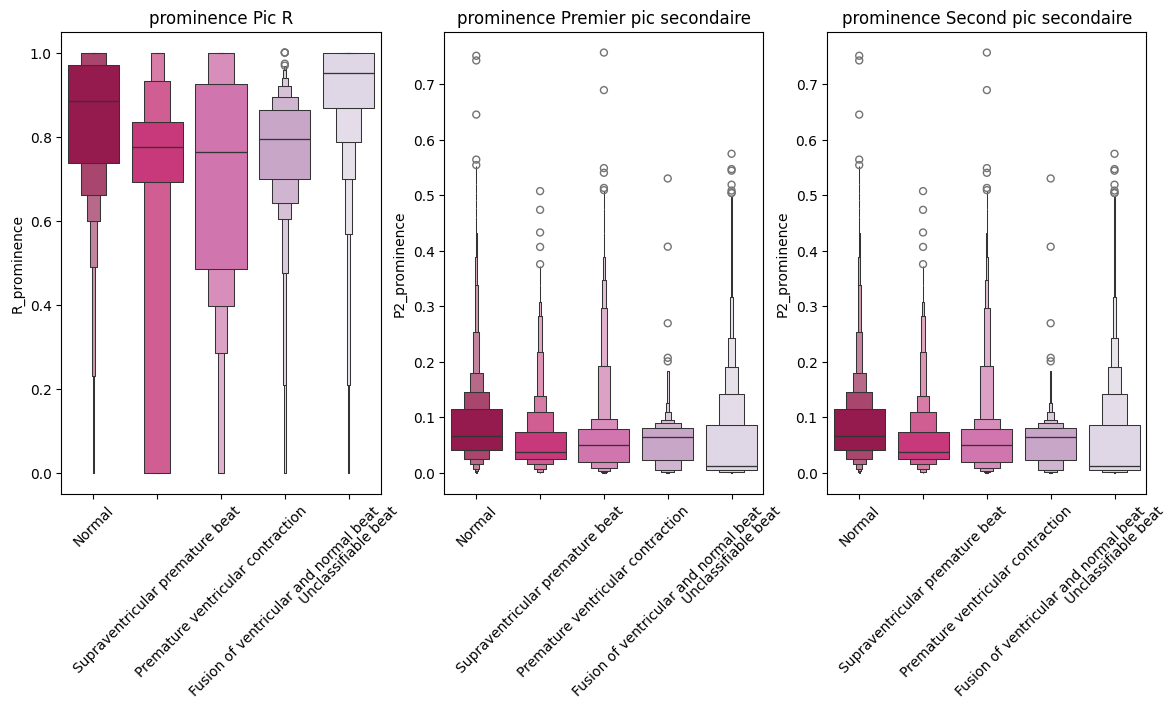

In [59]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(131)
sns.boxenplot(data=Waves,x=target_str,y='R_prominence',ax=ax,palette='PuRd_r')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('')
ax.set_title('prominence Pic R')

ax = fig.add_subplot(132)
sns.boxenplot(data=Waves,x=target_str,y='P2_prominence',ax=ax,palette='PuRd_r')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('')
ax.set_title('prominence Premier pic secondaire')

ax = fig.add_subplot(133)
sns.boxenplot(data=Waves,x=target_str,y='P2_prominence',ax=ax,palette='PuRd_r')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('')
ax.set_title('prominence Second pic secondaire')


#### Durée du signal

C:\Users\carol\AppData\Local\Temp\ipykernel_16268\2185260371.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=Waves,x=target_str,y='dur',ax=ax,palette='PuRd_r')


Text(0.5, 0, '')

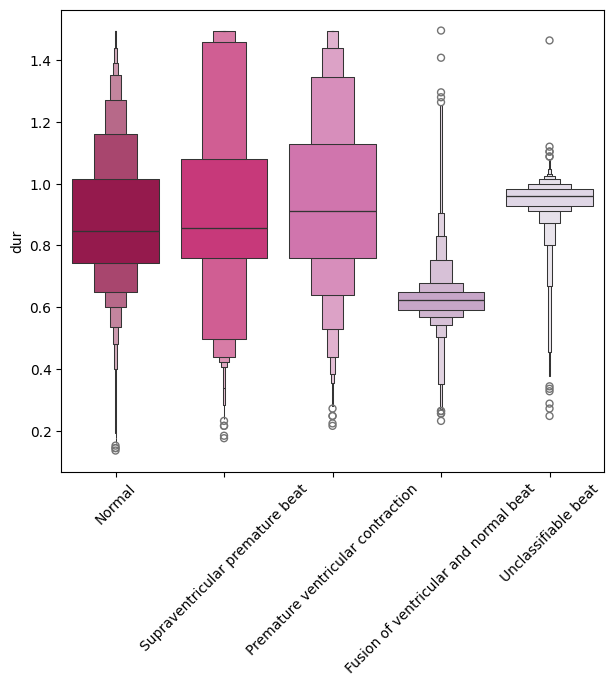

In [25]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot()
sns.boxenplot(data=Waves,x=target_str,y='dur',ax=ax,palette='PuRd_r')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('')

la classe 3 est courte  

## Catch 22

Catch22 est un module qui calcule des attributs de signaux apparemment efficace pour des méthodes ML

In [26]:
import pycatch22 as c22

In [36]:
f24 = np.zeros((X.shape[0],24))
for k in range(X.shape[0]):
    catch22_output = c22.catch22_all(X[k,:],catch24=True)
    f24[k,:] = catch22_output['values']

In [39]:
X2 = pd.DataFrame(f24, columns = catch22_output['names'])

## Concatenation pics et catch22: base de données finale

In [41]:
XX = pd.concat((Waves,X2),axis=1)

In [42]:
XX.head()

,R,R_width,R_height,R_prominence,P1,P1_width,P1_height,P1_prominence,P2,P2_width,...,DN_OutlierInclude_n_001_mdrmd,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr,DN_Mean,DN_Spread_Std
0,0.664,0.039388,1.000000,1.000000,0.272,0.138408,0.153833,0.055834,0.520,0.069339,...,0.524064,0.784876,8.0,1.336643,0.195122,0.853659,0.294524,0.615611,0.098419,0.176545
1,0.920,0.032684,1.000000,0.997151,0.272,0.099044,0.285026,0.219753,0.592,0.127996,...,0.545455,0.754295,11.0,1.703697,0.219512,0.146341,0.319068,0.651591,0.090010,0.160151
2,0.656,0.020095,0.964865,0.959459,0.232,0.088947,0.318149,0.266873,0.496,0.057448,...,0.417112,0.610125,8.0,1.359020,0.146341,0.853659,0.392699,0.725262,0.062104,0.139142
3,0.640,0.036068,1.000000,1.000000,0.224,0.050063,0.139043,0.070692,0.432,0.128624,...,0.443850,0.812680,8.0,1.318925,0.219512,0.853659,0.245437,0.578643,0.084084,0.161252
4,0.936,0.047209,0.953052,0.953052,0.264,0.114071,0.252878,0.120345,0.784,0.074667,...,0.165775,0.860059,8.0,1.543619,0.146341,0.731707,0.220893,0.524557,0.116567,0.186651


<Axes: >

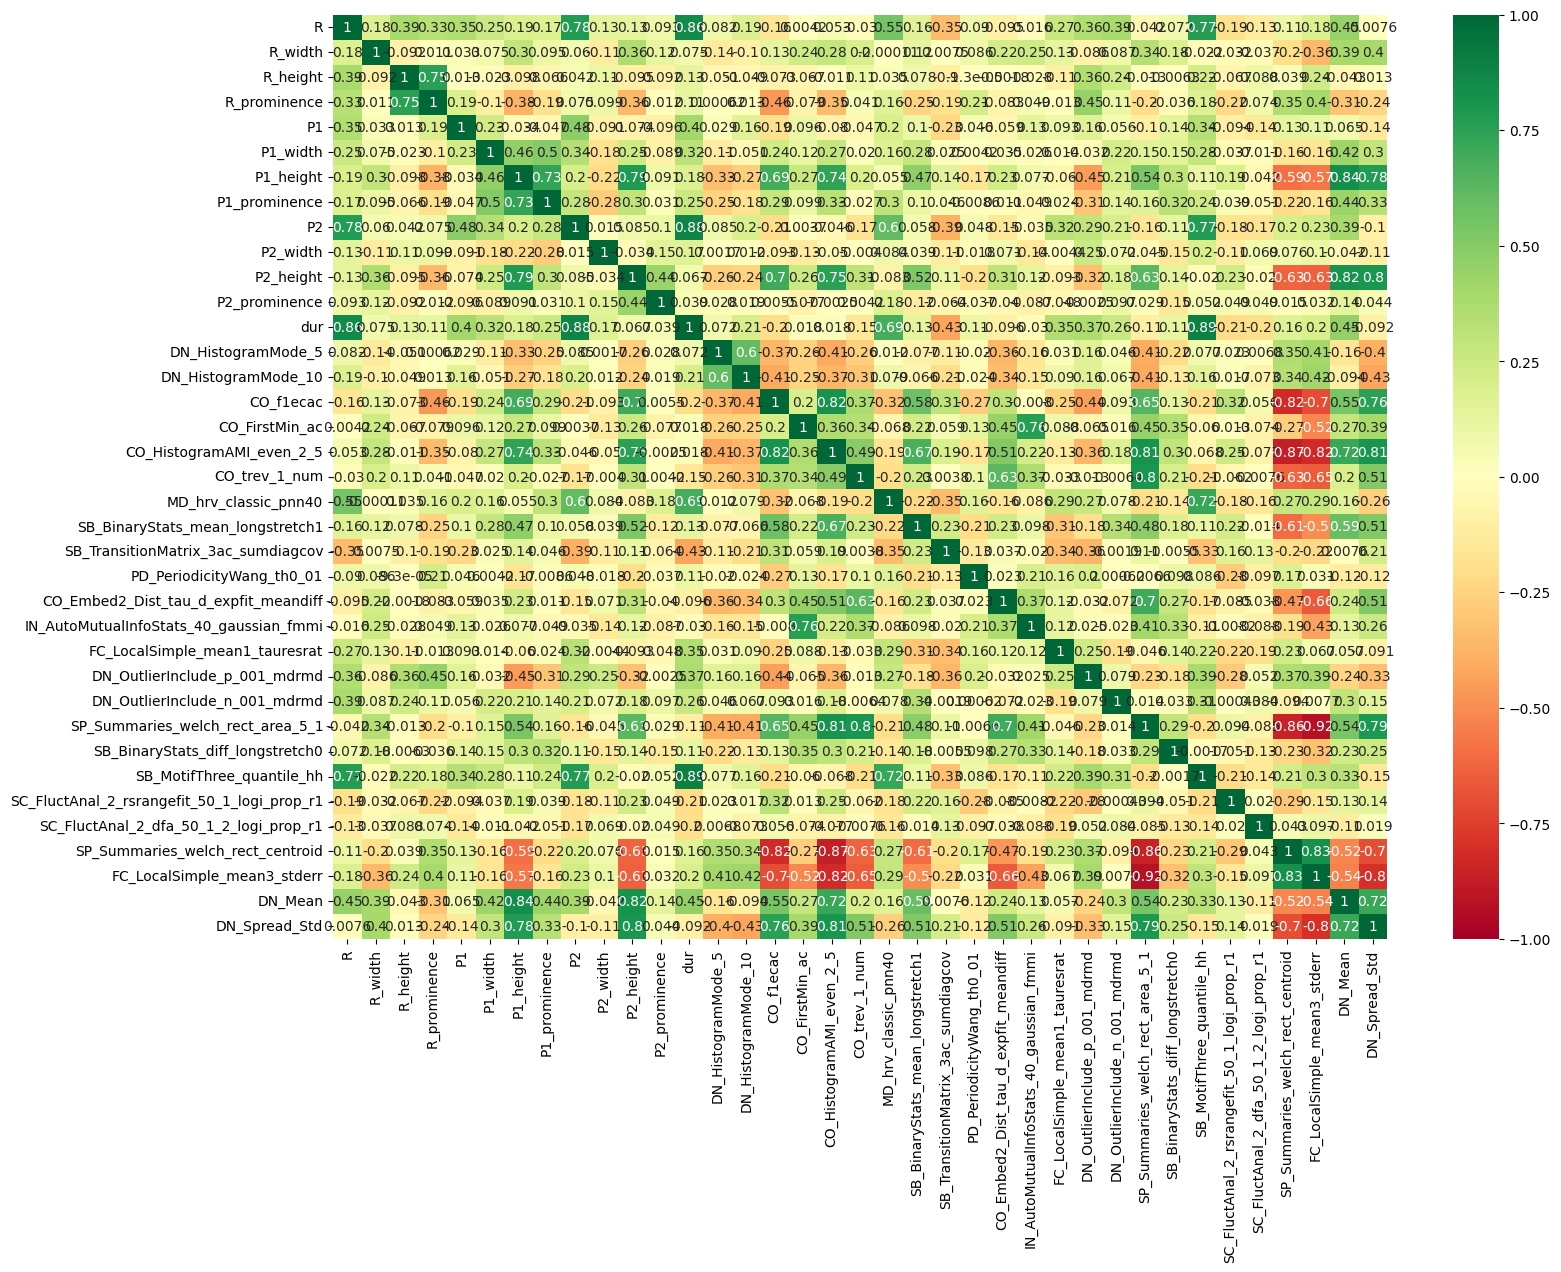

In [47]:
fig = plt.figure(figsize=(17,12))
ax = fig.add_subplot()
sns.heatmap(XX.corr(),cmap='RdYlGn',annot=True,vmax=1,vmin=-1)

In [50]:
XX['target'] = y

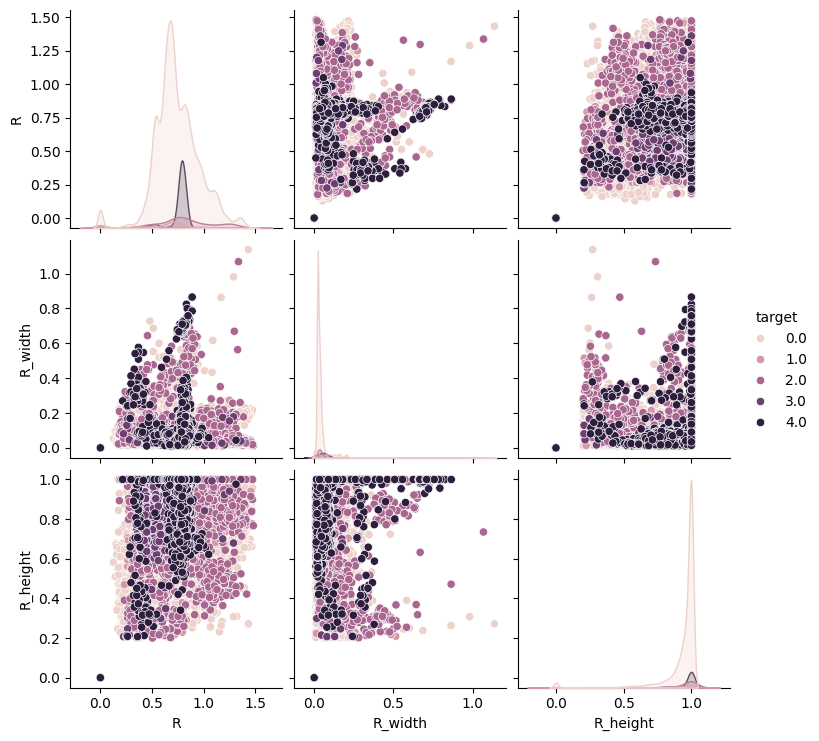

In [51]:
sns.pairplot(XX[['R','R_width','R_height','target']],hue='target')

In [54]:
XX.to_csv('../data/processed/features_mitbih_train.csv',index=False)